In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import cv2
from keras.utils import to_categorical
import math

In [3]:
# Load and preprocess tags
train_tag = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/5002/data/Data_Q3/tarin_tag.txt', sep=",", header=None)
train_tag.columns = ["video", "tag"]
train_tag['tag'] = to_categorical(train_tag['tag']).tolist()

In [4]:
# Function to load and process video
def process_video(file_path, frame_size, frame_count):
    cap = cv2.VideoCapture(file_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, frame_size, interpolation=cv2.INTER_CUBIC)
        frames.append(frame)
    cap.release()

    frames = np.array(frames)
    if len(frames) < frame_count:
        last_frame = frames[-1]
        while len(frames) < frame_count:
            frames = np.append(frames, [last_frame], axis=0)
    else:
        frame_indices = np.round(np.linspace(0, len(frames) - 1, frame_count)).astype(int)
        frames = frames[frame_indices]

    return frames

In [5]:
img_size = (60, 60)
frame_count = 20
video_path = '/content/drive/MyDrive/Colab Notebooks/5002/data/Data_Q3/train_video/'

In [6]:
x, y = [], []
for filename in os.listdir(video_path):
    if filename.endswith(".mp4"):
        video_frames = process_video(os.path.join(video_path, filename), img_size, frame_count)
        x.append(video_frames)
        tag = train_tag[train_tag['video'] == filename]['tag'].values[0]
        y.append(tag)
x, y = np.array(x), np.array(y)

In [7]:
x.shape

(2063, 20, 60, 60, 3)

In [8]:
y.shape

(2063, 15)

In [9]:
# Splitting dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1650, 20, 60, 60, 3)
y_train shape: (1650, 15)
x_test shape: (413, 20, 60, 60, 3)
y_test shape: (413, 15)


In [55]:
from keras.applications.vgg16 import VGG16
import tensorflow
from keras.models import Sequential
from keras.models import Model
from keras.layers import TimeDistributed, LSTM, Flatten, Dense, Dropout, Input
from keras.regularizers import l2

# Define the input layer
input_shape = (20, 60, 60, 3)  # (frames, height, width, channels)
input_layer = Input(shape=input_shape)

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(60, 60, 3))

# Freeze the layers of the VGG16 model
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(TimeDistributed(base_model, input_shape=input_shape))
model.add(TimeDistributed(Flatten()))

# LSTM
model.add(LSTM(256, return_sequences=False))

#Fully connected layer with L2 regularization
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.6))

# Output layer
model.add(Dense(15, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeD  (None, 20, 1, 1, 512)     14714688  
 istributed)                                                     
                                                                 
 time_distributed_21 (TimeD  (None, 20, 512)           0         
 istributed)                                                     
                                                                 
 lstm_10 (LSTM)              (None, 256)               787456    
                                                                 
 dense_20 (Dense)            (None, 64)                16448     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 15)              

In [56]:
history =model.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test))

Epoch 1/30
52/52 [==============================] - 17s 274ms/step - loss: 2.7322 - accuracy: 0.1624 - val_loss: 2.3667 - val_accuracy: 0.3002
Epoch 2/30
52/52 [==============================] - 13s 245ms/step - loss: 2.1688 - accuracy: 0.3412 - val_loss: 2.0476 - val_accuracy: 0.4044
Epoch 3/30
52/52 [==============================] - 13s 245ms/step - loss: 1.7490 - accuracy: 0.4867 - val_loss: 1.7706 - val_accuracy: 0.4939
Epoch 4/30
52/52 [==============================] - 13s 243ms/step - loss: 1.4766 - accuracy: 0.5685 - val_loss: 1.6359 - val_accuracy: 0.5424
Epoch 5/30
52/52 [==============================] - 13s 242ms/step - loss: 1.1446 - accuracy: 0.6855 - val_loss: 1.5157 - val_accuracy: 0.5593
Epoch 6/30
52/52 [==============================] - 12s 241ms/step - loss: 1.0052 - accuracy: 0.7230 - val_loss: 1.4296 - val_accuracy: 0.5981
Epoch 7/30
52/52 [==============================] - 12s 241ms/step - loss: 0.8372 - accuracy: 0.7770 - val_loss: 1.3934 - val_accuracy: 0.5908

In [57]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy * 100}%")#0.6,30

13/13 [==============================] - 3s 194ms/step - loss: 1.4518 - accuracy: 0.6659
Test Accuracy: 66.5859580039978%


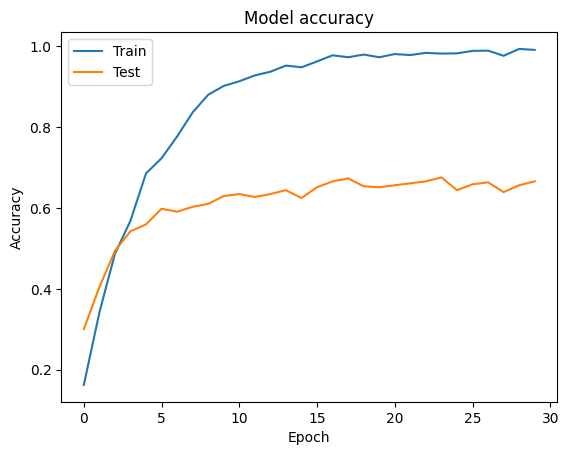

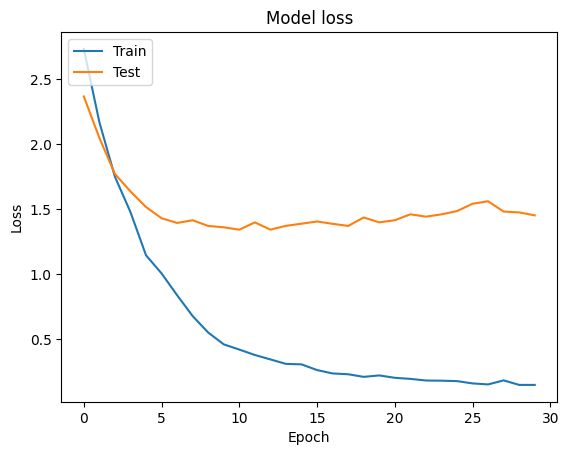

In [58]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
path = '/content/drive/MyDrive/Colab Notebooks/5002/data/Data_Q3/test_video/'
out_x = []
filenames = []
img_size = (60, 60)  # Adjusted to be consistent with the previous definition
frames = 20

for filename in os.listdir(path):
    if filename.endswith(".mp4"):
        video_path = os.path.join(path, filename)
        video_frames = process_video(video_path, img_size, frames)
        filenames.append(filename)
        out_x.append(video_frames)

out_x = np.array(out_x)

In [17]:
out_x.shape

(562, 20, 60, 60, 3)

In [30]:
prediction = model.predict(out_x)
prediction=np.argmax(prediction,axis=1)

18/18 [==============================] - 4s 173ms/step


In [32]:
result_df=pd.DataFrame()
result_df['file_name'] = filenames
result_df['label'] = prediction
#result_df

In [33]:
#result_df.to_csv('Q3_output.csv', index=False)